In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

# auto. choose CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Function to load CIFAR-10 dataset
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the directory containing CIFAR-10 batches
cifar10_dir = '/content/drive/MyDrive/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load metadata (labels)
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# Load training data
train_data = []
train_labels = []

for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format
train_labels = np.array(train_labels)

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.2,scale=(0.02, 0.1),value=1.0, inplace=False)
])


# Convert to TensorDataset and apply transformations
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)

# Split into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Load test dataset
cifar_test_path = '/content/drive/MyDrive/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0
test_labels = np.array(test_batch[b'labels'])

# Define transformation
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format

# Convert test dataset to Tensor
test_dataset = [(test_transform(img), label) for img, label in zip(test_images, test_labels)]

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


# Train function with Early Stopping
def train_model(model, train_loader, val_loader, epochs=50):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)  # Adjust learning rate
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

    scheduler = StepLR(optimizer, step_size=6, gamma=0.85)  # Learning rate decay

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        scheduler.step()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    print("Training complete.")

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel, skip_kernel, stride=1, bias=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=kernel[0], stride=stride, padding=kernel[1], bias=bias)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel[0],
                               stride=1, padding=kernel[1], bias=bias)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=skip_kernel[0], padding=skip_kernel[1], stride=stride, bias=bias),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, in_planes, num_layers, num_blocks, kernel, skip_kernel, num_classes=10, bias=True):
        if not isinstance(num_blocks, list):
            raise Exception("num_blocks parameter should be a list of integer values")
        if num_layers != len(num_blocks):
            raise Exception("Residual layers should be equal to the length of num_blocks list")
        super(ResNet, self).__init__()
        self.kernel = kernel
        self.skip_kernel = skip_kernel
        self.in_planes = in_planes
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=kernel[0],
                               stride=1, padding=kernel[1], bias=bias)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.num_layers = num_layers
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1, bias=bias)
        for i in range(2, num_layers+1):
            setattr(self, "layer"+str(i), self._make_layer(block, 2*self.in_planes, num_blocks[i-1], stride=2, bias=bias))
        finalshape = list(getattr(self, "layer"+str(num_layers))[-1].modules())[-2].num_features
        self.multiplier = 4 if num_layers == 2 else (2 if num_layers == 3 else 1)
        self.dropout = nn.Dropout(0.2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.linear = nn.Linear(finalshape, num_classes)
        self.path = "./project1_model.pt"

    def _make_layer(self, block, planes, num_blocks, stride, bias=True):
        strides = [stride] + [1]*(num_blocks-1)
        custom_layers = []
        for stride in strides:
            custom_layers.append(block(self.in_planes, planes,self.kernel,self.skip_kernel, stride, bias))
            self.in_planes = planes
        return nn.Sequential(*custom_layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for i in range(1, self.num_layers+1):
            out = eval("self.layer" + str(i) + "(out)")
        out = F.avg_pool2d(out, 4*self.multiplier)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

    def saveToDisk(self):
        torch.save(self.state_dict(), self.path)

    def loadFromDisk(self):
        self.load_state_dict(torch.load(self.path))

# put models to devices (CPU/GPU)
# model = ResNet(BasicBlock, 32, 4, [4, 4, 4, 2],kernel=(3,1),skip_kernel=(1,0), num_classes=10, bias=True).to(device)
model = ResNet(BasicBlock, 64, 3, [3, 4, 3], kernel=(3,1), skip_kernel=(1,0), num_classes=10, bias=True).to(device)


# Print the number of parameters
from torchsummary import summary
summary(model, (3, 32, 32))

# Train the model
train_model(model, train_loader, val_loader, epochs=100) #change epoch

# Generate submission file
model.eval()
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14

In [5]:
torch.save(model.state_dict(), "resnet_model_4M.pt")

In [8]:
cifar10_classes = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Submission file saved.


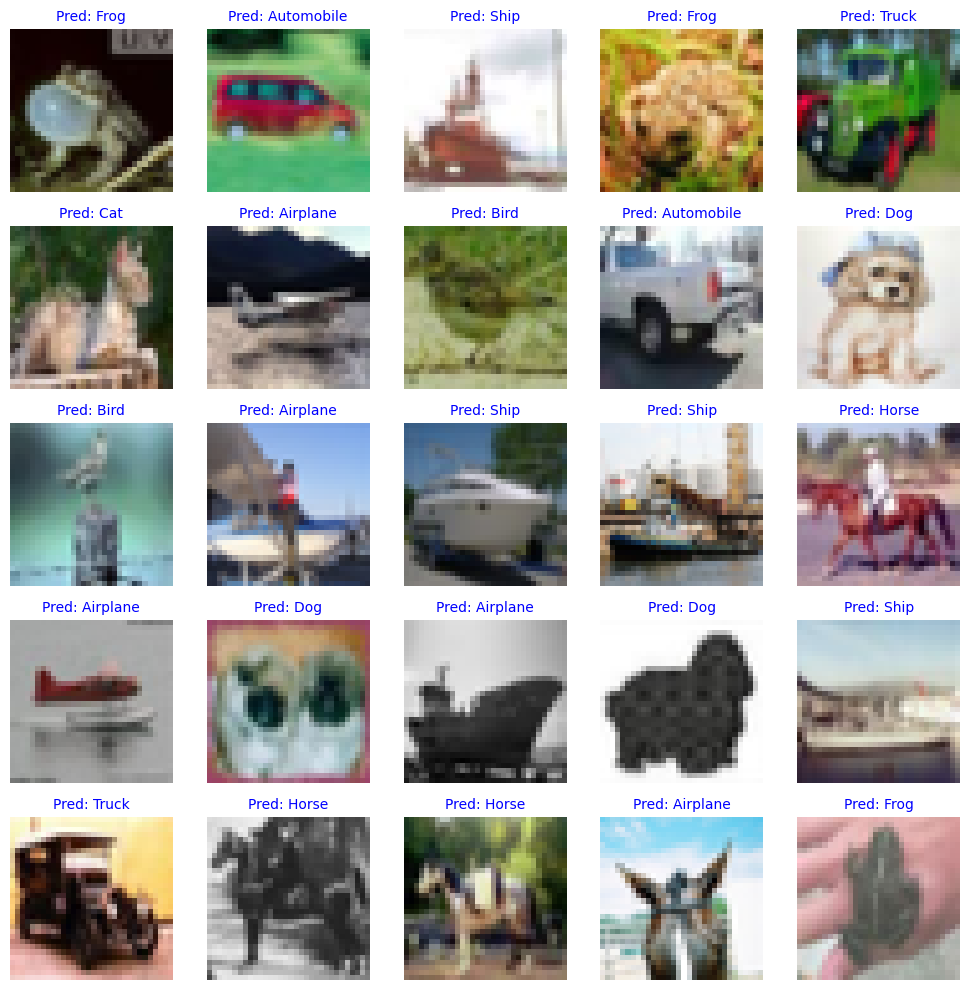

In [9]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

# # Load your trained model
# model_path = "/content/resnet_model_new.pth"  # Change this to your model's actual path
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Assuming your model class is defined as "YourModelClass"
# model.load_state_dict(torch.load(model_path, map_location=device))  # Load the trained weights
model.to(device)
model.eval()  # Set to evaluation mode

# Load CIFAR test batch
cifar_test_path = '/content/drive/MyDrive/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
submission_test_batch = load_cifar_batch(cifar_test_path)
submission_test_images = submission_test_batch[b'data'].astype(np.float32) / 255.0


# Define transformation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Convert test dataset to Tensor
submission_test_dataset = [test_transform(img) for img in submission_test_images]
submission_test_loader = DataLoader(submission_test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Initialize predictions
predictions = []

# Visualization setup
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid
axes = axes.flatten()

# Run inference
with torch.no_grad():
    for i, images in enumerate(submission_test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

        # Visualize first 25 images
        if i == 0:
            for j in range(min(25, len(images))):  # Limit to 25 images
                img = submission_test_images[j]  # Get original image
                label = predicted[j].item()

                axes[j].imshow(img)
                axes[j].set_title(f"Pred: {cifar10_classes[label]}", fontsize=10, color="blue")
                axes[j].axis("off")

# Save predictions to CSV
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/content/submission_resnet_4M.csv', index=False)
print("Submission file saved.")

# Show visualization
plt.tight_layout()
plt.show()
